## Calibrating a Classifier for a Balanced Dataset

In [1]:
# import libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
# for preparation
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# evaluation
from sklearn.metrics import(
    roc_auc_score,
    brier_score_loss,
    roc_curve,
)

# to get the calibrated points
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [2]:
# get data

X,y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X)
y = pd.Series(y)

X.head()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
y.value_counts()

1    357
0    212
dtype: int64

In [4]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [5]:
y_train.value_counts()

1    249
0    149
dtype: int64

In [6]:
y_train.value_counts()/len(y_train)

1    0.625628
0    0.374372
dtype: float64

## Naive Bayes

In [7]:
# lets initialize a GaussianNB model object

nb = GaussianNB()

nb.fit(X_train,y_train)

GaussianNB()

In [8]:
# get the ROC scores

preds_train = nb.predict_proba(X_train)[:,1]
print('ROC score for train data : {}'.format(roc_auc_score(y_train,preds_train)))

preds_test = nb.predict_proba(X_test)[:,1]
print('ROC score for test data : {}'.format(roc_auc_score(y_test,preds_test)))

ROC score for train data : 0.9893803401525566
ROC score for test data : 0.9854497354497355


- We can see that the model performs quite well with both the training and test datasets as given by the roc_auc_score

## Brier Score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [9]:
# get the Brier scores for all models

bs_train = brier_score_loss(y_train,preds_train)
print('Brier score for train data : {}'.format(bs_train))

bs_test = brier_score_loss(y_test,preds_test)
print('Brier score for test data : {}'.format(bs_test))

Brier score for train data : 0.051000734589839614
Brier score for test data : 0.07586880889698372


The brier score also seems to be doing fair. Lets check by plotting the calibration curve

In [10]:
# lets write a function to plot the calibration curve

def plot_calibration_curve(y_test,preds_test,bins):
    
    plt.figure(figsize=(10,14))
    plt.subplot(2,1,1)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, preds_test, n_bins=bins,strategy='uniform')
    plt.plot(mean_predicted_value, fraction_of_positives,label='Gaussian NB')


    # draw the perfect calibrated line
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='--',c='red',label='Perfect Calibration')
    plt.legend(loc='best');
    plt.title('Calibration Curve')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')

    # lets plot the distribution of the predicted probabilities as well
    plt.subplot(2,1,2)
    plt.hist(preds_test,range=(0,1),bins=bins,density=True,alpha = 0.5)
    plt.title('Density')
    plt.xlabel('')

    plt.show()

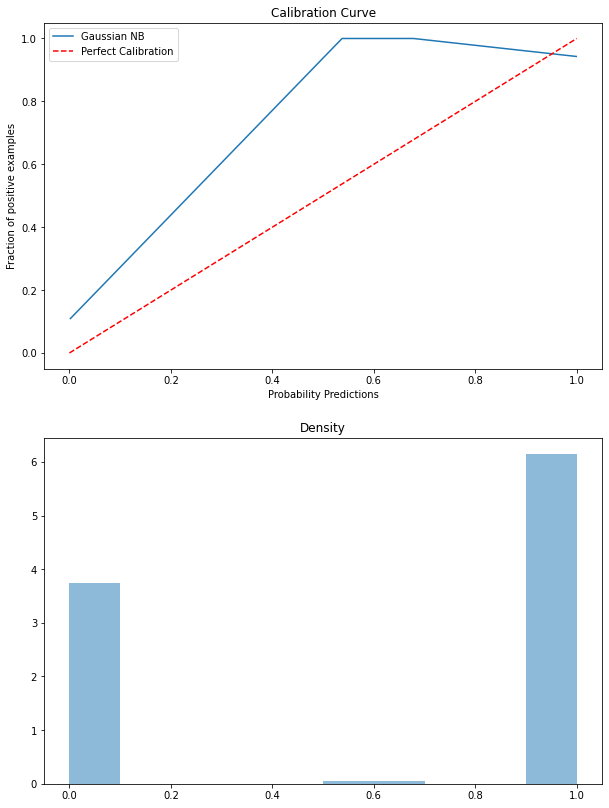

In [11]:
plot_calibration_curve(y_test,preds_test,bins=10)

The probability of the Gaussian NB model is uncalibrated. Prediction Distribution seems to be spreaded though

## Probability Re-calibration
- Now we'll try to calibrate our Gaussian model predictions

In [12]:
# create a calibrated classifier cv 

# for isotonic method
clf_iso = CalibratedClassifierCV(base_estimator=nb, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
# its best to keep some hold sample data, but for less data, we can do this method of cv
clf_iso.fit(X_test,y_test) 
# get the predictions
preds_iso = clf_iso.predict_proba(X_test)[:,1]


# for sigmoid method - or platt method
clf_sigmoid = CalibratedClassifierCV(base_estimator=nb, n_jobs=2, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test,y_test) 
# get the predictions
preds_sigmoid = clf_sigmoid.predict_proba(X_test)[:,1]

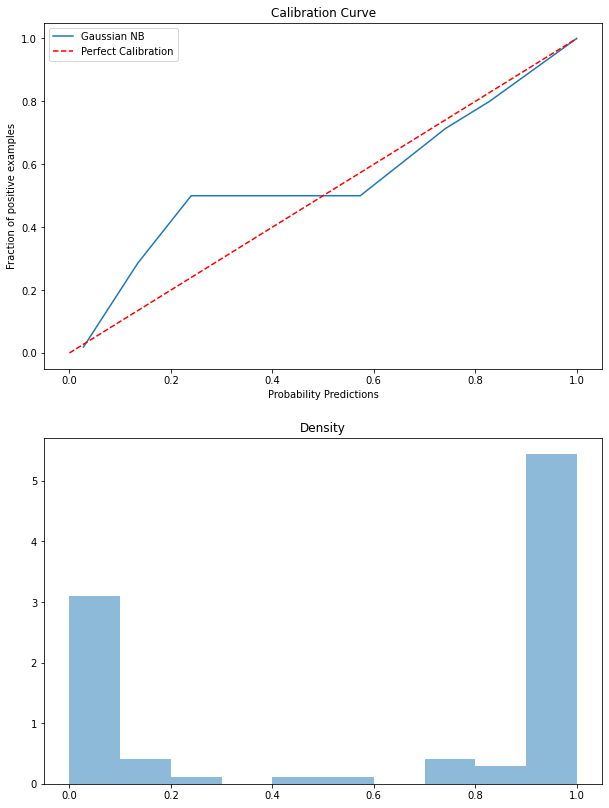

In [13]:
plot_calibration_curve(y_test,preds_iso,bins=10)

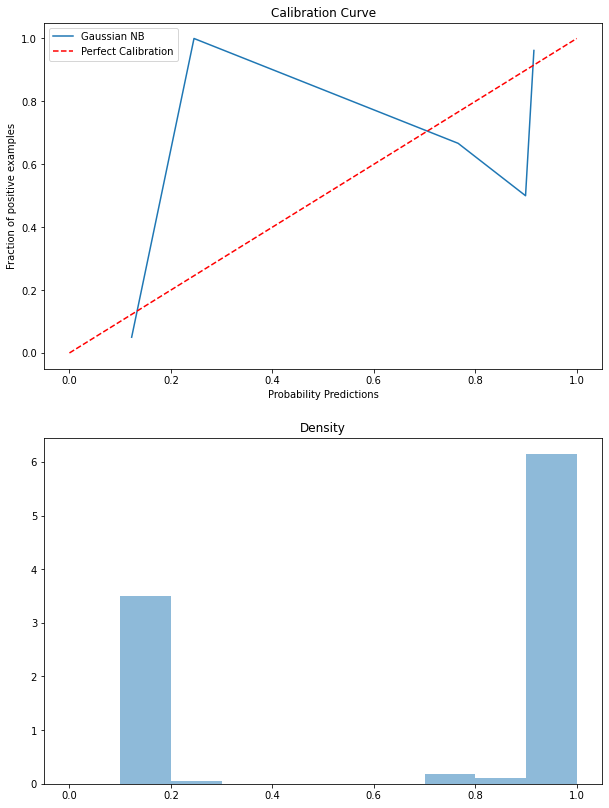

In [14]:
plot_calibration_curve(y_test,preds_sigmoid,bins=10)

For this particular dataset, the Isotonic Calibration worked better than Plat Scaling

In [15]:
# checking the roc score for this classifiers

print('ROC score for test data ISOTONIC: {}'.format(roc_auc_score(y_test,preds_iso)))

ROC score for test data ISOTONIC: 0.9920634920634921


In [16]:
# checking the roc score for this classifiers

print('ROC score for test data SIGMOID: {}'.format(roc_auc_score(y_test,preds_sigmoid)))

ROC score for test data SIGMOID: 0.9901528512639624


In [17]:
# the original score before calibrating
# get the ROC scores

preds_train = nb.predict_proba(X_train)[:,1]
print('ROC score for train data : {}'.format(roc_auc_score(y_train,preds_train)))

preds_test = nb.predict_proba(X_test)[:,1]
print('ROC score for test data : {}'.format(roc_auc_score(y_test,preds_test)))

ROC score for train data : 0.9893803401525566
ROC score for test data : 0.9854497354497355


- Seems the model performance also seems to be better with the calibrated classifier

In [18]:
# checking the brier scores - expecting to be much better

bs_test = brier_score_loss(y_test,preds_iso)
print('Brier score for test data ISOTONIC: {}'.format(bs_test))

Brier score for test data ISOTONIC: 0.03755352664684502


In [19]:
bs_test = brier_score_loss(y_test,preds_sigmoid)
print('Brier score for test data SIGMOID: {}'.format(bs_test))

Brier score for test data SIGMOID: 0.054142198229985936


In [20]:
# BEFORE calibration scores
bs_train = brier_score_loss(y_train,preds_train)
print('Brier score for train data : {}'.format(bs_train))

bs_test = brier_score_loss(y_test,preds_test)
print('Brier score for test data : {}'.format(bs_test))

Brier score for train data : 0.051000734589839614
Brier score for test data : 0.07586880889698372


- As expected, the brier scores for both the methods are pretty much better and improved.